In [1]:
import matplotlib.pyplot as plt
import tqdm
from napari import Viewer
import numpy as np


In [2]:
viewer = Viewer()
file = r"C:\Users\Daniel\Desktop\Work\lab\Data\drive-download-20230301T232528Z-002\R216-arc002.nd2"
# open image with reader plugin
viewer.open(file, plugin='napari-nikon-nd2')

[<Image layer 'R216-arc002' at 0x228804064d0>,
 <Image layer 'R216-arc002 [1]' at 0x228fe64a310>,
 <Image layer 'R216-arc002 [2]' at 0x2289d14fe10>,
 <Image layer 'R216-arc002 [3]' at 0x22885887fd0>]

In [3]:
from nd2reader import ND2Reader

# get the metadata from the nd2 file
with ND2Reader(file) as images:
    metadata = images.metadata
print(metadata)

{'height': 1024, 'width': 1024, 'date': datetime.datetime(2023, 2, 10, 13, 33, 52), 'fields_of_view': [0], 'frames': [0], 'z_levels': range(0, 30), 'z_coordinates': [2822.027, 2822.2270000000003, 2822.402, 2822.6020000000003, 2822.827, 2823.002, 2823.202, 2823.402, 2823.6020000000003, 2823.827, 2823.9770000000003, 2824.177, 2824.377, 2824.6020000000003, 2824.802, 2824.9770000000003, 2825.152, 2825.377, 2825.552, 2825.802, 2826.002, 2826.2270000000003, 2826.402, 2826.6020000000003, 2826.777, 2827.027, 2827.2270000000003, 2827.377, 2827.6020000000003, 2827.802], 'total_images_per_channel': 30, 'channels': ['DAPI', 'EGFP', 'TRITC', 'Cy5'], 'pixel_microns': 0.124296113880448, 'num_frames': 1, 'experiment': {'description': 'ND Acquisition', 'loops': []}, 'events': []}


In [4]:
# Blue is dapi, green is gfp, red VGaT, far red is VGLUT3.

for i, channel in enumerate(metadata['channels']):
    # rename TRITC to VGaT
    if channel == 'TRITC':
        channel = 'VGaT'
    # rename CY5 to VGLUT3
    if channel == 'Cy5':
        channel = 'VGluT3'
    # create a variable for each channel
    exec(f'{channel} = viewer.layers[{i}].data')
    # rename the layer
    viewer.layers[i].name = channel

    print(f'Channel {i} is {channel}')

# set the color of layers
for i, layer in enumerate(viewer.layers):
    if layer.name == 'DAPI':
        layer.colormap = 'blue'
    elif layer.name == 'EGFP':
        layer.colormap = 'green'
    elif layer.name == 'VGaT':
        layer.colormap = 'red'
    elif layer.name == 'VGluT3':
        layer.colormap = 'magenta'



Channel 0 is DAPI
Channel 1 is EGFP
Channel 2 is VGaT
Channel 3 is VGluT3


In [5]:
from napari.types import ImageData, LabelsData
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import local_maxima, remove_small_objects, dilation
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import relabel_sequential as _relabel_sequential, clear_border as _clear_border, expand_labels, watershed as _watershed, random_walker as _random_walker
import pandas as pd

def voronoi_otsu_labeling(image:ImageData, spot_sigma: float = 2, outline_sigma: float = 2) -> LabelsData:
    """Voronoi-Otsu-Labeling is a segmentation algorithm for blob-like structures such as nuclei and granules with high signal intensity on low-intensity background. 
    
    Parameters
    ----------
    image : ndarray
        Input image.
    spot_sigma : float, optional
        Standard deviation of the Gaussian kernel used to smooth the image. Controls how close detected cells can be
    outline_sigma : float, optional
        Standard deviation of the Gaussian kernel used to smooth the outlines. Controls how precise segmented objects are.
    
    Returns
    -------
    labels : ndarray
        Labeled image.
    
    References
    ----------
    .. [1] https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb
    """
    image = np.asarray(image)

    # blur and detect local maxima
    blurred_spots = gaussian(image, spot_sigma)
    spot_centroids = local_maxima(blurred_spots)

    # blur and threshold
    blurred_outline = gaussian(image, outline_sigma)
    threshold = threshold_otsu(blurred_outline)
    binary_otsu = blurred_outline > threshold

    # determine local maxima within the thresholded area
    remaining_spots = spot_centroids * binary_otsu

    # start from remaining spots and flood binary image with labels
    labeled_spots = label(remaining_spots)
    labels = _watershed(binary_otsu, labeled_spots, mask=binary_otsu)

    return labels

def gauss_otsu_labeling(image:ImageData, outline_sigma: float = 2) -> LabelsData:
    """Gauss-Otsu-Labeling can be used to segment objects such as nuclei with bright intensity on
    low intensity background images.

    Parameters
    ----------
    image : ndarray
        Input image.
    outline_sigma : float, optional
        Standard deviation of the Gaussian kernel used to smooth the outlines. Controls how precise segmented objects are.
    
    Returns
    -------
    labels : ndarray
        Labeled image.
    """
    image = np.asarray(image)

    # blur
    blurred_outline = gaussian(image, outline_sigma)

    # threshold
    threshold = threshold_otsu(blurred_outline)
    binary_otsu = blurred_outline > threshold

    # connected component labeling
    labels = label(binary_otsu)

    return labels

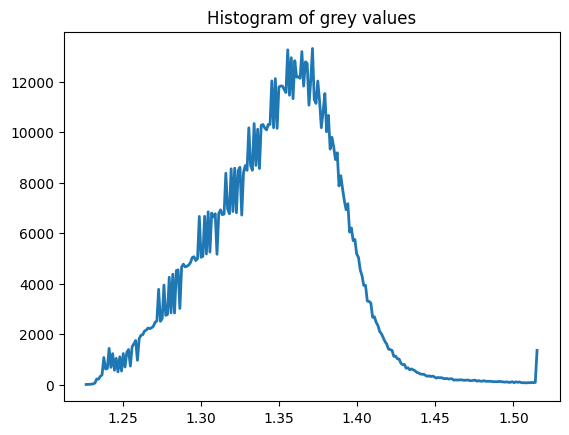

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


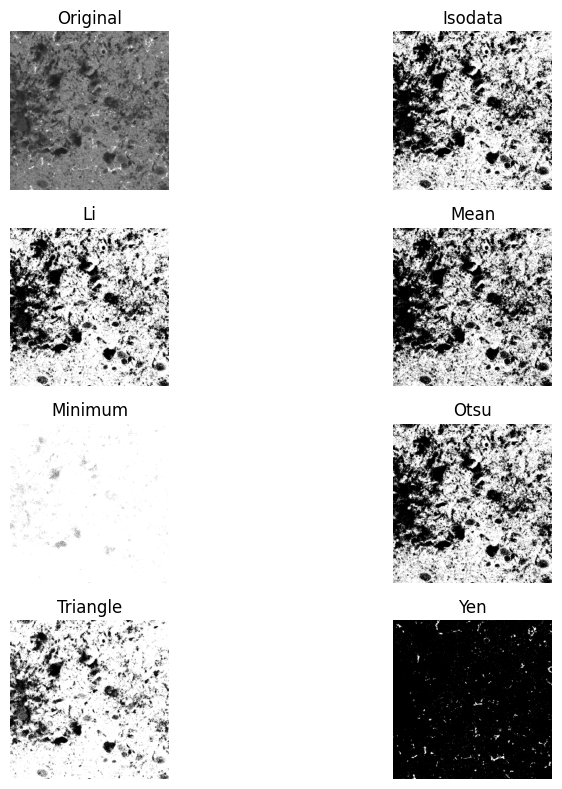

In [6]:
from skimage.filters import try_all_threshold
from skimage.exposure import histogram, adjust_sigmoid
vgt = np.asarray(EGFP.data)[0]

# increase contrast
from skimage.exposure import adjust_sigmoid, adjust_gamma
vgt = adjust_gamma(vgt, gamma=0.5)
# increase contrast
vgt = adjust_gamma(vgt, gamma=0.1)

# get the histogram of the image
hist, hist_centers = histogram(vgt)

# plot the histogram
fig, ax = plt.subplots()
ax.plot(hist_centers, hist, lw=2)
ax.set_title('Histogram of grey values')
plt.show()

# try all thresholding methods
fig, ax = try_all_threshold(vgt, figsize=(10, 8), verbose=True)
plt.show()

In [7]:
from skimage.filters import threshold_yen
vgt = np.asarray(EGFP.data)
vgt = adjust_gamma(vgt, gamma=0.5)
vgt = adjust_gamma(vgt, gamma=0.1)

# threshold the image
threshold = threshold_yen(vgt)
binary = vgt > threshold

gfp_labels = label(binary)
gfp_labels = remove_small_objects(gfp_labels, min_size=5)
# expand labels to deal with low resolution better 
gfp_labels = expand_labels(gfp_labels, 2)
viewer.add_labels(gfp_labels, name='gfp_labels')


<Labels layer 'gfp_labels' at 0x22886f125d0>

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


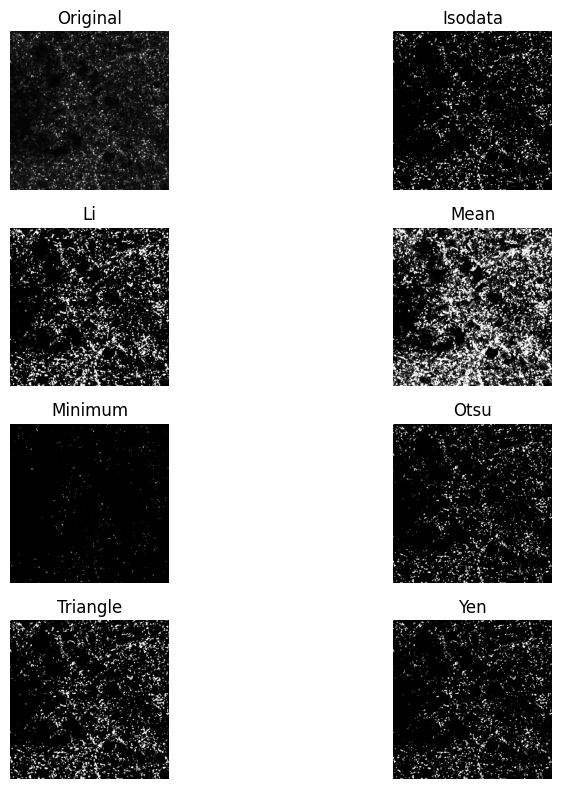

In [8]:
from skimage.filters import try_all_threshold
vgt = np.asarray(VGaT.data)[0]
# try all thresholding methods
fig, ax = try_all_threshold(vgt, figsize=(10, 8), verbose=True)
plt.show()

In [9]:
# from skimage.filters import threshold_isodata
# vgt = np.asarray(VGaT.data)
# thresh = threshold_isodata(vgt)
# vgt = vgt > thresh
vgat_labels = voronoi_otsu_labeling(VGaT.data, spot_sigma=1.0, outline_sigma=4)

viewer.add_labels(vgat_labels, name='vgat_labels')

<Labels layer 'vgat_labels' at 0x22886d61790>

In [10]:
vgat_props = regionprops_table(vgat_labels, intensity_image=VGaT, properties=('label', 'area', 'mean_intensity', 'max_intensity', 'min_intensity', 'centroid'))
vgat_props = pd.DataFrame(vgat_props)

print(f'Number of VGaT cells: {len(vgat_props)}')
# intense_vgat where the mean intensity is greater 0.5 standard deviations of the mean
low_std = vgat_props['mean_intensity'].mean() - 0.7 * vgat_props['mean_intensity'].std()

print(f'Low std: {low_std}')

intense_vgat = vgat_props[vgat_props['mean_intensity'] > low_std]

# remove all labels from vgat_labels that are not in intense_vgat df
vgat_labels = np.where(np.isin(vgat_labels, intense_vgat['label']), vgat_labels, 0)

print(f'Number of intense VGaT cells: {len(intense_vgat)}')

Number of VGaT cells: 13426
Low std: 808.8444459386205
Number of intense VGaT cells: 10076


In [11]:
# add the labels to the viewer
viewer.add_labels(vgat_labels, name='intense_vgat')

<Labels layer 'intense_vgat' at 0x22888479990>

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


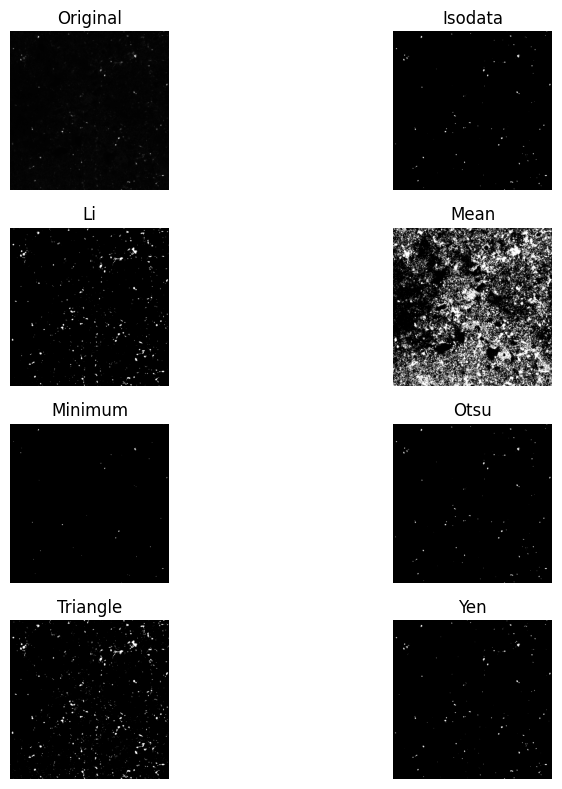

In [12]:
vgt = np.asarray(VGluT3.data)
# try all thresholding methods
fig, ax = try_all_threshold(vgt[0], figsize=(10, 8), verbose=True)
plt.show()

In [13]:
from skimage.filters import threshold_triangle

vgt = np.asarray(VGluT3.data)
thresh = threshold_triangle(vgt)
vgt = vgt > thresh
viewer.add_image(vgt, name='vglut triangle')

<Image layer 'vglut triangle' at 0x22894a2f410>

In [14]:
vglut_labels = voronoi_otsu_labeling(VGluT3.data, spot_sigma=1, outline_sigma=2)
viewer.add_labels(vglut_labels, name='vglut_labels')

<Labels layer 'vglut_labels' at 0x22886ce5890>

In [15]:
# create a mask where all labels overlap
# this ensures that the we're looking at colocalized Vgat and Vglut within the same GFP+ cell
mask = np.zeros_like(gfp_labels)
# mask of all Vglut and Vgat colocalizations
mask[np.logical_and(gfp_labels > 0, vglut_labels > 0)] = 1
# mask of all colocalizations in GFP+ cells
mask[np.logical_and(mask > 0, vgat_labels > 0)] = 1

# convert mask into individual labels 
from skimage.measure import label
mask_labels = label(mask)

# add mask labels layer
viewer.add_labels(mask_labels, name='mask_labels')

# expand the mask labels to supplement for the voronoi segmentation
mask_labels_dialated = dilation(mask_labels, footprint=np.ones((9,9,9)))

# convert the mask labels back into a binary mask
mask_binary = mask_labels_dialated > 0

# add mask binary layer
viewer.add_labels(mask_binary, name='mask_binary')

<Labels layer 'mask_binary' at 0x22888442d10>

In [16]:
# create binary mask of Vgat+ cells
vgat_binary = vgat_labels > 0

# create binary mask of Vglut+ cells
vglut_binary = vglut_labels > 0

# create binary mask of GFP+ cells
gfp_binary = gfp_labels > 0

# add binary layers
viewer.add_labels(vgat_binary, name='vgat_binary')
viewer.add_labels(vglut_binary, name='vglut_binary')
viewer.add_labels(gfp_binary, name='gfp_binary')

<Labels layer 'gfp_binary' at 0x228949758d0>

In [17]:
import tqdm
from skimage.measure import regionprops_table
import pandas as pd

props = regionprops_table(vgat_labels, vglut_binary, properties=('label', 'mean_intensity'))

df = pd.DataFrame(props)

# remove all labels that don't colocalize with Vglut mask
colo = df[df['mean_intensity'] != 0]
colo_vgat = np.where(np.isin(vgat_labels, colo['label']), vgat_labels, 0)
viewer.add_labels(colo_vgat, name='colo_vgat')

<Labels layer 'colo_vgat' at 0x2289484cbd0>

In [18]:
import tqdm
from skimage.measure import regionprops_table
import pandas as pd

# use regionprops_table to get the properties of the Vgat+ cells that colocalize with Vglut
props = regionprops_table(vglut_labels, vgat_binary, properties=('label', 'mean_intensity', 'area', 'bbox'))

# create a dataframe from the properties
df = pd.DataFrame(props)

# create new df where mean_intensity >= 0.5
colo = df[df['mean_intensity'] != 0]

colo_vglut = np.where(np.isin(vglut_labels, colo['label']), vglut_labels, 0)
viewer.add_labels(colo_vglut, name='colo_vglut')

<Labels layer 'colo_vglut' at 0x22893d66b50>

In [19]:
# get Vgat colocalizations within GFP+ cells
props = regionprops_table(colo_vgat, gfp_binary, properties=('label', 'mean_intensity', 'area', 'bbox'))
df = pd.DataFrame(props)
colo = df[df['mean_intensity'] > 0]
colo_vgat_gfp = np.where(np.isin(colo_vgat, colo['label']), colo_vgat, 0)


# get Vglut colocalizations within GFP+ cells
props = regionprops_table(colo_vglut, gfp_binary, properties=('label', 'mean_intensity', 'area', 'bbox'))
df = pd.DataFrame(props)
colo = df[df['mean_intensity'] > 0]
colo_vglut_gfp = np.where(np.isin(colo_vglut, colo['label']), colo_vglut, 0)

# add colocalizations to viewer
viewer.add_labels(colo_vgat_gfp, name='colo_vgat_gfp')
viewer.add_labels(colo_vglut_gfp, name='colo_vglut_gfp')

<Labels layer 'colo_vglut_gfp' at 0x22886c51cd0>

## ANALYSIS

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import regionprops_table

In [21]:
properties = ['label', 'area']
colo_vgat_gfp_table = pd.DataFrame(regionprops_table(colo_vgat_gfp, properties=properties))

# multiply each area by the pixel size to get the area in um
colo_vgat_gfp_table['area'] = colo_vgat_gfp_table['area'] * metadata['pixel_microns']

# change column names
colo_vgat_gfp_table.columns = ['label', 'area µm^2']

print(colo_vgat_gfp_table)

colo_vgat_table = pd.DataFrame(regionprops_table(colo_vgat, properties=properties))
colo_vgat_table['area'] = colo_vgat_table['area'] * metadata['pixel_microns']
colo_vgat_table.columns = ['label', 'area µm^2']
print(colo_vgat_table)

     label   area µm^2
0        9   60.035023
1      133   40.023349
2      135   40.023349
3      141   38.656091
4      210  116.589755
..     ...         ...
566  13201   20.508859
567  13203   57.300508
568  13206   55.808955
569  13406    9.695097
570  13408   22.249004

[571 rows x 2 columns]
      label  area µm^2
0         9  60.035023
1        25  86.510095
2        26  70.600193
3        36  96.329488
4       103  79.549513
...     ...        ...
1268  13341  53.571625
1269  13398  24.486334
1270  13406   9.695097
1271  13408  22.249004
1272  13416  34.181431

[1273 rows x 2 columns]


Number of Vgat colocalized with VGlut3 in GFP+:  571
Number of VGlut3 colocalized with Vgat in GFP+:  209
Average size of Vgat colocalized with VGlut3 in GFP+:  102.5819528440164
Average size of VGlut3 colocalized with Vgat in GFP+:  85.90764567533299


Text(0.5, 1.0, 'Distribution of Vgat colocalized with VGlut3 in GFP+ over the size of the colocalization')

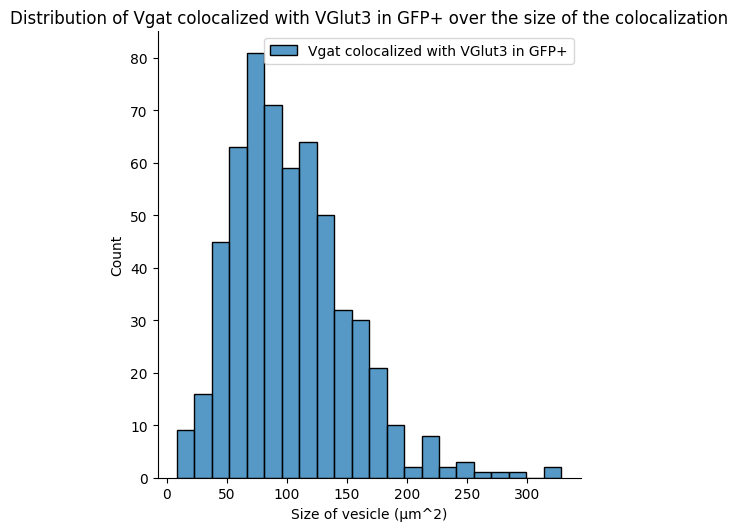

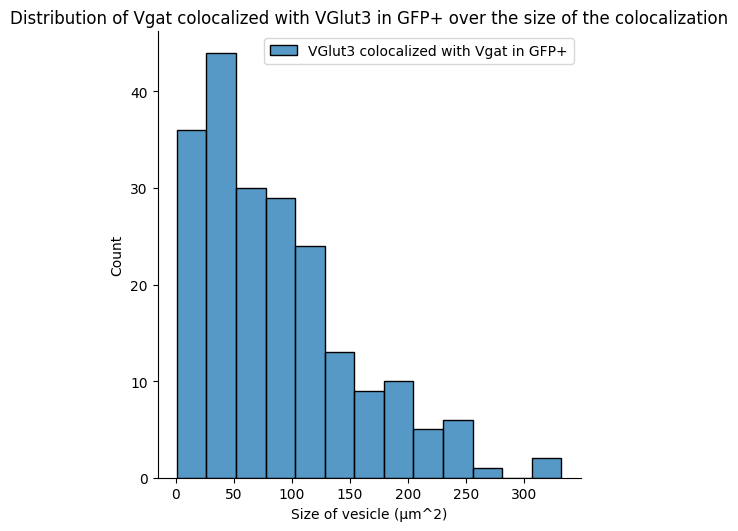

In [22]:
print('Number of Vgat colocalized with VGlut3 in GFP+: ', len(regionprops(colo_vgat_gfp)))

print('Number of VGlut3 colocalized with Vgat in GFP+: ', len(regionprops(colo_vglut_gfp)))

# average size of Vgat colocalized with VGlut3 in GFP+
vgat_colo_vglut_size = np.mean([prop.area for prop in regionprops(colo_vgat_gfp)])
vglut_colo_vgat_size = np.mean([prop.area for prop in regionprops(colo_vglut_gfp)])
print('Average size of Vgat colocalized with VGlut3 in GFP+: ', vgat_colo_vglut_size * metadata['pixel_microns'])
print('Average size of VGlut3 colocalized with Vgat in GFP+: ', vglut_colo_vgat_size * metadata['pixel_microns'])

# plot the distribution of Vgat colocalized with VGlut3 in GFP+ over the size of the colocalization
vgat_colo_vglut_size = [prop.area * metadata['pixel_microns'] for prop in regionprops(colo_vgat_gfp)]
vglut_colo_vgat_size = [prop.area * metadata['pixel_microns'] for prop in regionprops(colo_vglut_gfp)]



sns.displot(vgat_colo_vglut_size, label='Vgat colocalized with VGlut3 in GFP+')
plt.legend()
plt.xlabel('Size of vesicle (µm^2)')
plt.ylabel('Count')
plt.title('Distribution of Vgat colocalized with VGlut3 in GFP+ over the size of the colocalization')
sns.displot(vglut_colo_vgat_size, label='VGlut3 colocalized with Vgat in GFP+')
plt.legend()
plt.xlabel('Size of vesicle (µm^2)')
plt.ylabel('Count')
plt.title('Distribution of Vgat colocalized with VGlut3 in GFP+ over the size of the colocalization')


R216-arc20 [spacing]
G323-BNST-20x [3]
R216-arc001 [3]
R213-PVH20x [spacing]
R213-pvh [3]
R213-bnst20x001 [spacing]
R213-bnst [spacing]
R213-Arc20x [spacing]
R213-arc2 (2_10_23) [3]
R213-arc [3]
G323BNST [3]
G323Arc1001 [3]
G323Arc1 [3]
